In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import collections
import einops
import matplotlib.pyplot as plt
import math
import numpy as np
import torch as t
from torch import nn
import transformers
from IPython.core.display import HTML, display

import w3d2_tests
from days.utils import *


tokenizer = transformers.GPT2Tokenizer.from_pretrained("gpt2")
tokenizer._add_tokens(["[BEGIN]", "[END]"])
tokenizer.pad_token = "[END]"
tokenizer.eos_token = "[END]"

In [ ]:
gen_model = transformers.GPT2LMHeadModel.from_pretrained("gpt2")

In [3]:
eval_model = w3d2_tests.get_minigpt("model.pt")

### VWAS for minigpt

Let's see if VWAS correspond to our intuitive understanding of what should activate the heads.

`value-weighted attention scores (from, to) = score(from,to)*norm(V(from))`

In [55]:
texts = [
    "[BEGIN] Now that we've tried a one-layer model, let's try a two-layer model.",
    "[BEGIN] Now that we've tried a one-layer model, let's try a two layer model.",
    "[BEGIN] Now that we've tried a one-layer model, let's try something else.",
]

In [56]:
input_ids = tokenizer(texts, return_tensors='pt', padding=True).input_ids

In [57]:
eval_model(input_ids).shape

torch.Size([3, 21, 50259])

In [58]:
weighted_attns = eval_model.weighted_attention(input_ids)
# -> [n_layer, n_batch, n_head, q, k]
weighted_attns.shape

torch.Size([2, 3, 8, 21, 21])

In [59]:
vwas_1_4 = weighted_attns[1,:,4,:,:]
vwas_1_5 = weighted_attns[1,:,5,:,:]
vwas_1_6 = weighted_attns[1,:,6,:,:]

In [60]:
vwas_1_4.shape

torch.Size([3, 21, 21])

In [61]:
print(t.sum(vwas_1_4, dim=[-1,-2]),
      t.sum(vwas_1_5, dim=[-1,-2]),
      t.sum(vwas_1_6, dim=[-1,-2]))

tensor([7.9436, 6.6319, 6.1856]) tensor([52.7071, 52.9230, 51.7804]) tensor([22.2051, 21.7206, 20.3310])


In [62]:
print(t.max(t.max(vwas_1_4, dim=-1).values, dim=-1).values,
      t.max(t.max(vwas_1_5, dim=-1).values, dim=-1).values,
      t.max(t.max(vwas_1_6, dim=-1).values, dim=-1).values)

tensor([1.3423, 0.6032, 0.2870]) tensor([1.7162, 1.7162, 1.7162]) tensor([1.2685, 0.6566, 0.6566])


In [66]:
input_ids[:,15:]
# 1st sentence: ( a, one), ( -,layer), (layer, model), ( model,,)
#                15,  7     17,   9        18,  10         19, 11
# 2nd sentence: ( a, one), ( model,,)
#               15,   7        18,11
# 3rd sentence: 

tensor([[  257,   734,    12, 29289,  2746,    13],
        [  257,   734,  7679,  2746,    13, 50258],
        [ 1223,  2073,    13, 50258, 50258, 50258]])

In [67]:
input_ids

tensor([[50257,  3844,   326,   356,  1053,  3088,   257,   530,    12, 29289,
          2746,    11,  1309,   338,  1949,   257,   734,    12, 29289,  2746,
            13],
        [50257,  3844,   326,   356,  1053,  3088,   257,   530,    12, 29289,
          2746,    11,  1309,   338,  1949,   257,   734,  7679,  2746,    13,
         50258],
        [50257,  3844,   326,   356,  1053,  3088,   257,   530,    12, 29289,
          2746,    11,  1309,   338,  1949,  1223,  2073,    13, 50258, 50258,
         50258]])

In [68]:
def get_token_idx(word, tokenizer, inputs):
    tokenized_word = tokenizer(word).input_ids
    assert len(tokenized_word) == 1, tokenized_word
    token = tokenized_word[0]
    idxs = (inputs == token).nonzero()
    return idxs
get_token_idx(",", tokenizer, input_ids)

tensor([[ 0, 11],
        [ 1, 11],
        [ 2, 11]])

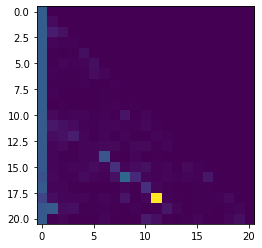

In [69]:
plt.imshow(vwas_1_4[1])

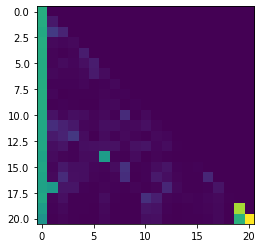

In [70]:
plt.imshow(vwas_1_4[2])

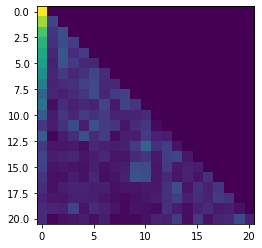

In [71]:
plt.imshow(vwas_1_5[1])

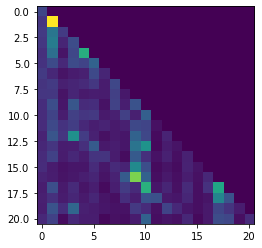

In [72]:
plt.imshow(vwas_1_6[1])

In [78]:
t.sum(vwas_1_4).item()

20.76110076904297

In [79]:
t.save(eval_model, )

TypeError: save() missing 1 required positional argument: 'f'